# Import basic libraries

Let's import some basic stuff

## TODO
- Add the nodes in the CityJSON file, keeping the relationships between nodes and edges (linestrings). The nodes have semantics and atttributes.
- Find a small area and compute widths.
- Create LoD0.1 with single lines and attributes for two-way and same for LoD0.2.

# Ideas for modelling

1. Every city object contains `MultiPoints` (nodes of LoD0.1), `MultiLineStrings` (edges of LoD0.1) and `MultiSurfaces `(for LoD1+).
2. Every city object contains `MultiLineStrings` (geometry of edges of LoD0.1) and `MultiSurfaces` (for LoD1+). The network topology (nodes and edges) is defined in its own `"+network"` portion of the city model.
3. Every city object has its own `MultiSurfaces` (for LoD1+). Then the actual network (nodes, edges and their geometry) is stored in `"+network"`.
4. Every node is its own city object. Every edge is its own city object. Every surface is its own city object. Then `CityObjectGroups` are used to relate them.

### Fix for `fiona`

*`fiona` has an issue with GDAL 3.0. Better set your `GDAL_DATA` path to fiona's installation (contains GDAL 2.4.4) prior to running this script.*

In [1]:
import geopandas
import pandas as pd
import osmnx as ox
import networkx as nx
import shapely

# Define variables

Here is where you can setup the environment to work with your data.

### Data variables

In [2]:
roads_file = 'data/Shawinigan/ShawiniganMPtoP.gpkg'
epsg = 32618
bgt = False

epsg_str = "EPSG:{}".format(epsg)

# Toronto - 26917
# Montreal - 32188
# Austin - 2277
# Shawinigan - 32618
# NL - 28992

### Database setup

In [3]:
pg_user = "alabetski"
pg_pass = ""
pg_host = "localhost"
pg_port = 5432
pg_database = "road_widths"

# Download the OSM data

This will load the osm file to a network

In [4]:
aerial_roads = geopandas.read_file(roads_file)
aerial_roads.crs = epsg_str

bbox = aerial_roads.to_crs("EPSG:4326").total_bounds

Load the OSM data:

In [5]:
# # We don't want edges to be loaded twice
ox.config(all_oneway=True, useful_tags_way=['bridge', 'tunnel', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed', 'service', 'access', 'area', 'landuse', 'width', 'est_width', 'junction', 'layer'])

network_graph = ox.graph_from_bbox(bbox[3], bbox[1], bbox[2], bbox[0], simplify=False)
# We simplify the graph afterwards, so that osmids are not "smashed" together
network_graph = ox.simplify_graph(network_graph, strict=False)

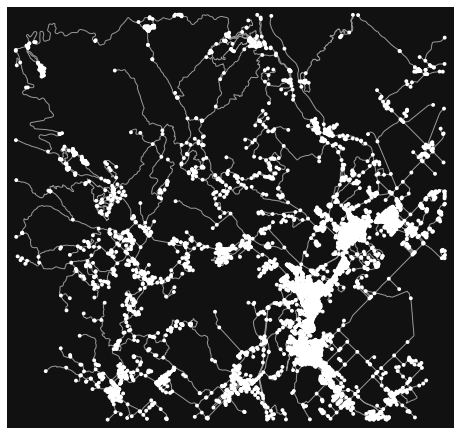

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [6]:
ox.plot_graph(network_graph)

We create `UUID` for every edge:

In [7]:
import uuid
import hashlib
import json
from cityhash import CityHash32

hashes = []
def compute_hashes():
    for u,v,a in network_graph.edges(data=True):
        temp = {
            "osmid": a['osmid'],
            "length": a['length']
        }
        a['uuid'] = CityHash32(uuid.uuid4().hex)
        hashes.append(a['uuid'])

compute_hashes()
# Ensure no conflict between the UUIDs
while len(hashes) != len(set(hashes)):
    print(len(hashes))
    hashes = []
    print("Found conflicts! Recomputing...")
    compute_hashes()

print("Done")

Done


Then we export the edges to a GeoDataFrame:

In [8]:
nodes, edges = ox.graph_to_gdfs(network_graph)

edges = edges.to_crs(epsg_str)

len(edges)

7060

In [9]:
edges.to_file('output/initial_network.gpkg', layer='edges', driver='GPKG')
nodes.to_file('output/initial_network.gpkg', layer='nodes', driver='GPKG')

print("Initial network exported.")

Initial network exported.


## Filter drive and service roads only

Filter roads to only motorways:

In [10]:
highway_types = [
    "primary",
    "secondary",
    "motorway",
    "trunk",
    "tertiary",
    "unclassified",
    "residential",

    "motorway_link",
    "trunk_link",
    "primary_link",
    "secondary_link",
    "tertiary_link",

    "living_street",
    "service",
    "pedestrian",
#     "track",
    "bus_guideway",
    "escape",
    "raceway",
    "road"
]

road_edges = edges[(edges['highway'].isin(highway_types))]

filtered_network = ox.graph_from_gdfs(nodes, road_edges)
filtered_network = ox.utils_graph.remove_isolated_nodes(filtered_network)

print("Connected components after filtering: {}".format(nx.number_weakly_connected_components(filtered_network)))

road_nodes, road_edges = ox.graph_to_gdfs(filtered_network)

road_edges.to_file('output/filtered_network.gpkg', layer='edges', driver='GPKG')
road_nodes.to_file('output/filtered_network.gpkg', layer='nodes', driver='GPKG')

print("Filtered network: {} edges, {} nodes".format(len(road_edges), len(road_nodes)))

Connected components after filtering: 5
Filtered network: 6263 edges, 4745 nodes


# Calculate carriageways and lanes
- Compute the carriageways only from OSM attributes.
- Compute road width:
     - We exclude intersections.
- How we create the carriageways for twoway streets and more specifically for intersections.

NOTE: Case of a two-way road where we figure out that the road width doesn't fit two lanes (special case were two ways share the same carriageway).

In [11]:
from shapely.ops import unary_union
from shapely.geometry import Point, LineString, MultiLineString

def get_vertex(line, first=True):
    """Returns the first or last vertex of the line as a Point"""
    if line.type == "LineString":        
        return Point(line.coords[0 if first else -1])
    elif line.type == "MultiLineString" and len(line.geoms) == 1:
        return Point(line.geoms[0].coords[0 if first else -1])
    else:
        raise TypeError("This is MultiLineString with many parts!")

## Calculate width

### Using PostGIS

This is to calculate the widths in PostGIS using [this](https://github.com/willemhoffmans/bgt_wegbreedte/).

Let's import stuff and create the connection with the database:

In [12]:
# SO https://gis.stackexchange.com/a/239231

# Imports
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
import pandas as pd
import geopandas as gpd

# Creating SQLAlchemy's engine to use
engine = create_engine('postgresql://{}@{}:{}/{}'.format(pg_user, pg_host, pg_port, pg_database))

Let's create the required functions in the database:

In [14]:
import psycopg2

conn = psycopg2.connect(dbname=pg_database, user=pg_user, password=pg_pass)

file = open("wegbreedtes_script.sql", "r")
conn.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT)
cursor = conn.cursor()
cursor.execute(file.read())

Now we export the BGT roads to the database with the appropriate names:

In [15]:
export_aerial = aerial_roads.copy()
export_aerial['geometrie_vlak'] = export_aerial['geometry'].apply(lambda x: WKTElement(x.wkt, srid=epsg))

export_aerial.drop('geometry', 1, inplace=True)

if bgt:
    export_aerial = export_aerial.rename(columns={'function':'bgt_functie'})
else:
    export_aerial['bgt_functie'] = "rijbaan"

# Use 'dtype' to specify column's type
# For the geom column, we will use GeoAlchemy's type 'Geometry'
export_aerial.to_sql("wegdeel", engine, schema='bgt', if_exists='replace', index=False, 
                         dtype={'geometrie_vlak': Geometry('POLYGON', srid=epsg)})

Export the roads:

In [16]:
from shapely.geometry import MultiLineString

export_roads = road_edges.copy()
export_roads['geom'] = export_roads['geometry'].apply(lambda x: WKTElement(MultiLineString([x]).wkt, srid=epsg))

export_roads.drop('geometry', 1, inplace=True)

# Use 'dtype' to specify column's type
# For the geom column, we will use GeoAlchemy's type 'Geometry'
export_roads.to_sql("road_edges", engine, if_exists='replace', index=False, 
                         dtype={'geom': Geometry('MULTILINESTRING', srid=epsg)})

Now, run the function to compute the widths:

In [17]:
conn = psycopg2.connect(dbname=pg_database, user=pg_user, password=pg_pass)
conn.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT)

cursor = conn.cursor()

cursor.execute("SELECT wh_wegbreedte_bgt_generiek ('road_edges', 'uuid', false, 0, {});".format(epsg))
for c in cursor:
    print(c)

('OK!',)


Load the resulting table with widths:

In [18]:
road_widths = geopandas.GeoDataFrame.from_postgis("SELECT * FROM breedte_analyse_nieuw.gemiddeldebreedte", conn, geom_col='geom' )

road_widths = road_widths.rename(columns={"geom": "geometry"})

len(road_widths)

4266

# Create carriageways

We calculated the widths via PostGIS using [this](https://github.com/willemhoffmans/bgt_wegbreedte/) (embarassingly, the previous scripts didn't work).

Let's load the data with the width:

In [19]:
roads_init = road_widths.rename(columns={"wegvakid": "uuid"}).merge(road_edges.set_index("uuid"), on="uuid", suffixes=('', '_right'))

len(roads_init)

4266

Append the missing roads segments. We will set a road width of 0 for them. Also, we need to convert them to `MultiLineString` to match the rest of the geometries.

In [20]:
from shapely.geometry import MultiLineString
import numpy as np

def make_multilinestring(f):
    """Returns a geometry as MultiLineString if it is a LineString"""
    
    if f["geometry"].type == "LineString":
        return MultiLineString([f["geometry"]])
    
    return f["geometry"]

roads_init = pd.concat([roads_init, road_edges[road_edges['uuid'].isin(roads_init['uuid']) == False]], ignore_index=True)

roads_init.loc[roads_init[np.isnan(roads_init['oper_breedte'])].index, 'oper_breedte'] = 0

roads_init["geometry"] = roads_init.apply(make_multilinestring, axis=1)

len(roads_init)

6263

Cleanup duplicates:

In [21]:
def make_ccw(l):
    c = list(l.coords)
    if c[0][0] > c[-1][0]:
        c = c[::-1]
    l = LineString(c)
    
    return l

roads_init["wkt"] = roads_init["geometry"].apply(lambda l: make_ccw(l.geoms[0]).wkt)
roads_init = roads_init.drop_duplicates(subset=["wkt"])
roads_init = roads_init.drop(['wkt'], 1)

len(roads_init)

6263

Let's create the basic carriageways when `is_one_carriageway` is `false` (specific width and a two way street):

In [22]:
from shapely.ops import linemerge
import warnings

width_col = 'oper_breedte'

def find_neighbouring_edges(f, nodeid, remove_self=True):
    """Returns the road UUIDs of the neighbours of a feature at a given node"""
    
    uuids = [a['uuid'] for u, v, a in network_graph.in_edges(nodeid, data=True)] + [a['uuid'] for u, v, a in network_graph.out_edges(nodeid, data=True)]
    
    if remove_self:
        uuids.remove(f['uuid'])
    
    return roads_init[roads_init['uuid'].isin(uuids)]

def azimuth(point1, point2):
    '''azimuth between 2 shapely points (interval 0 - 360)'''
    angle = np.arctan2(point2.x - point1.x, point2.y - point1.y)
    return np.degrees(angle) if angle >= 0 else np.degrees(angle) + 360

def line_azimuth(line, beginning, min_length=0.001):
    """Return the azimuth of a LineString.
    
    Depending on the boolean provided, it will return the azimuth of the
    beginning (if True) or end (if False) of the LineString. In order to
    ensure stability, the algorithm expects that a min_length of segments
    is accounted for the two points tha will compute the azimuth.
    """
    
    if line.type == "MultiLineString":
        l = linemerge(line)
    else:
        l = line
    
    start_p = Point(l.coords[0 if beginning else -1])
    c_count = len(l.coords)
    for i in range(1, c_count):
        end_p = Point(l.coords[i if beginning else c_count - i - 1])
        tmp_line = LineString([start_p, end_p])
        if tmp_line.length > min_length:
            return azimuth(start_p, end_p)
    
    # If the min_length is too big, return the azimuth of the whole thing
    return azimuth(start_p, end_p)

def get_line_azimuth(line, reverse):
    """Returns the azimuth of a line based on its boundaries (end points).
    
    Better use the `line_azimuth` function instead!
    """
    if reverse:
        return azimuth(Point(line.coords[-1]), Point(line.coords[-2]))
    
    return azimuth(Point(line.coords[0]), Point(line.coords[1]))

def angle_of_features(f1, f2, nodeid, geom_column="geometry"):
    az = get_line_azimuth(f1[geom_column].geoms[0], f1['u'] != nodeid)
    n_az = get_line_azimuth(f2[geom_column].geoms[0], f2['u'] != nodeid)
        
    return abs(n_az - az)                
        

def is_one_carriageway(f, tolerance):
    return (f[width_col] < (6 - tolerance)) or (f[width_col] > (15 + tolerance))

def is_one_way(f):
    """Returns True if this feature is a one way"""
    
    if f['oneway'] == 'yes':
        return True
    
    if "junction" in f and f["junction"] == "roundabout":
        return True
    
    if "highway" in f and (f["highway"] == "motorway" or f["highway"] == "motorway_link"):
        return True
    
    return False

def get_continuation(f, neighbours, nodeid):
    if len(neighbours) == 1:
        return neighbours.iloc[0]
    
    for i, n in neighbours.reset_index().iterrows():
        theta = angle_of_features(f, n, nodeid)
        if theta > 160 and theta < 200:
            return n
    
    return None

def carriageway_placement(f):
    """Returns the width of the carriage ways"""
    if is_one_way(f):
        return 0
    
    u_neighbours = find_neighbouring_edges(f, f['u'])
    v_neighbours = find_neighbouring_edges(f, f['v'])
    
    if len(u_neighbours) == 1 and len(v_neighbours) == 1:
        un = u_neighbours.iloc[0]
        vn = v_neighbours.iloc[0]
        if un[width_col] > 6 and vn[width_col] > 6:
            return min(un[width_col], vn[width_col]) / 4
    
    if len(u_neighbours) > 1 and len(v_neighbours) > 1 and f["geometry"].length < 20:
        # Check the angle with some features
        cu = get_continuation(f, u_neighbours, f['u'])
        cv = get_continuation(f, v_neighbours, f['v'])
        if (not cu is None
            and not cv is None
            and (not is_one_carriageway(cu, 0)
                 or not is_one_carriageway(cv, 0))):
            return f[width_col] / 4
        else:
            return 0
    
    # Check if this is the last segment of a road which normally, if short, is
    # very much affected by the intersection and will end up with an unrealistically
    # high width. Therefore, we will choose its type by the previous segment of this
    # road.
    if f[width_col] > 15:
        c = get_continuation(f, u_neighbours, f['u'])
        if not c is None and not is_one_carriageway(c, 0):
            return c[width_col] / 4

        c = get_continuation(f, v_neighbours, f['v'])
        if not c is None and not is_one_carriageway(c, 0):
            return c[width_col] / 4

    if len(u_neighbours) > 1 and len(v_neighbours) == 1:
        n = v_neighbours.iloc[0]
        if n['geometry'].length > f['geometry'].length:
            if is_one_carriageway(n, 0):
                return 0
            else:
                return n[width_col] / 4
    if len(u_neighbours) == 1 and len(v_neighbours) > 1:
        n = u_neighbours.iloc[0]
        if n['geometry'].length > f['geometry'].length:
            if is_one_carriageway(n, 0):
                return 0
            else:
                return n[width_col] / 4

    # This is only the general case
    if is_one_carriageway(f, 0):
        return 0
    else:
        return f[width_col] / 4

def create_carriageway(f):
    geom = f['geometry']
    
    width = carriageway_placement(f)
    if width == 0:
        return geom
    
    # TODO: We check if it's an extreme and then we check if it's a dead-end
    #       in which case we just exclude or we return the original geometry
    
    left_way = geom.geoms[0].parallel_offset(width, 'left')
    right_way = geom.geoms[0].parallel_offset(width, 'right')
    result = left_way.union(right_way)
    
    # This happens when closed loops have too wide roads. Better return the original geometry here.
    if result.type == "LineString":
        warnings.warn("Feature {} is a dual carriageway, but returned only one way! We are recovering its original geometry.".format(f['uuid']))
        result = geom
    
    return result 

roads_init['carriage_ways'] = roads_init.apply(create_carriageway, axis=1)

init_ways = geopandas.GeoDataFrame(
    roads_init[
        ['uuid', 'u', 'v', 'carriage_ways']
    ],
    geometry='carriage_ways',
    crs=epsg_str)

init_ways.to_file('output/output.gpkg', layer='First pass - Carriageways', driver='GPKG')

print("Done")

# f = roads_init[roads_init['uuid'] == 3298967887].iloc[0]
# create_carriageway(f)

<ipython-input-22-44199d4beece>:167: UserWarning: Feature 750366773 is a dual carriageway, but returned only one way! We are recovering its original geometry.
  warnings.warn("Feature {} is a dual carriageway, but returned only one way! We are recovering its original geometry.".format(f['uuid']))


Done


## Join carriageways

Now, we join the individual network segments with each other:
1. if both are single carriageway there is nothing to do
2. if both are dual carriageways then we compute the midpoint of the end and start node and we join them there
3. if one is single and another is dual then we join the dual to the end node of the single one (making a triangle).

We also identify continuation between carriageways in intersections and join them.

In [23]:
from shapely.ops import substring, linemerge
from shapely.geometry import LineString, MultiLineString
import numpy as np
import warnings

def is_first_vertex(f, u_nodeid):
    return f['u'] == u_nodeid

def cut_line(geom, dist, reverse=False):
    if reverse:
        return substring(geom, 0, geom.length - dist)
    else:
        return substring(geom, dist, geom.length)

def reverse_line(line):
    """Returns the line in the reverse orientation"""
    return LineString(reversed(line.coords))

def midpoint(pa, pb):
    return Point((pa.x + pb.x) / 2, (pa.y + pb.y) / 2)

def count_carriageways(f):
    if f['carriage_ways'].type == "LineString":
        return 1
    else:
        return len(f['carriage_ways'].geoms)

def as_line(geom):
    """Return a LineString from geom regardless if it's a MultiLineString or not"""

    if geom.type == "LineString":
        return geom
    else:
        return geom.geoms[0]

def merge_dual_to_single(geom, p, firstVertex):
    left_cw = geom.geoms[0] # Get left carriage way
    right_cw = geom.geoms[1] # Get right carriage way
    
    if left_cw.length < 1 or right_cw.length < 1:
        left_p = get_vertex(left_cw, not firstVertex) # Last point of left line
        right_p = get_vertex(right_cw, firstVertex) # First point of right line

        left_line = LineString([p, left_p])
        right_line = LineString([right_p, p])
    else:
        left_line = cut_line(left_cw, 1, not firstVertex)
        right_line = cut_line(right_cw, 1, firstVertex)

        left_p = get_vertex(left_line, firstVertex)
        right_p = get_vertex(right_line, not firstVertex)

        # Create the left and right side of the "triangle"
        left_side = LineString((p, left_p))
        right_side = LineString((p, right_p))

        # Merge the parts together
        left_line = linemerge(left_side.union(left_line))
        right_line = linemerge(right_side.union(right_line))

        if not get_vertex(left_line, firstVertex).equals(p):
            left_line = reverse_line(left_line)
        if not get_vertex(right_line, not firstVertex).equals(p):
            right_line = reverse_line(right_line)

    return MultiLineString([left_line, right_line])

def pick_closests_to(multi_p, p):
    """Gets the closest point of multi_p to p"""
    
    final_p = multi_p.geoms[0]
    d = p.distance(final_p)
    for pp in multi_p:
        if p.distance(pp) < d:
            final_p = pp
            d = p.distance(pp)
    
    return final_p

def join_dual_ways(geom, other_geom, isU, firstVertex):
    """Returns the end of a dual carriageway based on the other side.
    
    geom --- The geometry of the dual carriageway to modify
    other_geom --- The geometry of the other dual carriageway
    isU --- Specifies if this is the U side of the other geometry
    firstVertex --- Specifies if this is the first vertex of geom
    """
    other_left_p = get_vertex(other_geom.geoms[0], isU)
    other_right_p = get_vertex(other_geom.geoms[1], not isU)

    if isU == firstVertex:
        temp_p = other_left_p
        other_left_p = other_right_p
        other_right_p = temp_p

    left_cw = geom.geoms[0] # Get left carriage way
    right_cw = geom.geoms[1] # Get right carriage way
    
    other_left_cw = other_geom.geoms[1 if isU == firstVertex else 0]
    other_right_cw = other_geom.geoms[0 if isU == firstVertex else 1]
    
    theta = line_azimuth(left_cw, firstVertex, min_length=5)
    theta = theta - line_azimuth(other_left_cw, isU, min_length=5)
    theta = abs(theta)
    
    straight = 135 < theta < 225 or 315 < theta or theta < 45

    p = left_cw.intersection(other_left_cw)
    if (p.type == "Point" or p.type == "MultiPoint") and not p.is_empty:
        if p.type == "MultiPoint":
            p = pick_closests_to(p, Point(left_cw.coords[0 if firstVertex else -1]))
        proj = left_cw.project(p)
        if firstVertex:
            if proj < left_cw.length / 2:
                left_line = substring(left_cw, proj, left_cw.length)
            else:
                left_line = left_cw
        else:
            if proj > left_cw.length / 2:
                left_line = substring(left_cw, 0, proj)
            else:
                left_line = left_cw
    else:
        left_p = get_vertex(left_cw, firstVertex) # First point of left line
        new_left_p = midpoint(left_p, other_left_p)
        
        if firstVertex:
            left_line = LineString([new_left_p] + left_cw.coords[1 if straight else 0:])
        else:
            left_line = LineString(left_cw.coords[:-1 if straight else None] + [new_left_p])
    
    p = right_cw.intersection(other_right_cw)
    if (p.type == "Point" or p.type == "MultiPoint") and not p.is_empty:
        if p.type == "MultiPoint":
            p = pick_closests_to(p, Point(right_cw.coords[-1 if firstVertex else 0]))
        proj = right_cw.project(p)
        if firstVertex:
            if proj > right_cw.length / 2:
                right_line = substring(right_cw, 0, proj)
            else:
                right_line = right_cw
        else:
            if proj < right_cw.length / 2:
                right_line = substring(right_cw, proj, right_cw.length)
            else:
                right_line = right_cw
    else:
        right_p = get_vertex(right_cw, not firstVertex) # Last point of right line
        new_right_p = midpoint(right_p, other_right_p)
        if firstVertex:
            right_line = LineString(right_cw.coords[:-1] + [new_right_p])
        else:
            right_line = LineString([new_right_p] + right_cw.coords[1:])
            
    return MultiLineString([left_line, right_line])

def find_next_road(f, neighbours, nodeid, firstVertex):
    """Returns the feature that counts as a continuation of this road (if any)"""
    
    if len(neighbours) == 0:
        return None
    
    if len(neighbours) == 1:
        return neighbours.iloc[0]
    
    other_feature = []
    
    axis_geom = as_line(f['geometry'])
    a = get_line_azimuth(axis_geom, not firstVertex)
    
    # Find out if there is only one other road with the same number of carriageways
    similar = 0 # number of similar carriageway-type roads in this intersection
    cw_count = count_carriageways(f)
    for i in range(len(neighbours)):
        n = neighbours.iloc[i]
        if count_carriageways(n) == cw_count:
            similar = similar + 1
            other_feature = n
    
    # If there is only one similar and this is a three-way, pick the similar
    if similar == 1 and len(neighbours) == 2:
        return other_feature
    
    ccc = neighbours.apply(count_carriageways, axis=1) == (1 if cw_count == 2 else 2)
    force_same_cw = len(neighbours[ccc]) == 2
    
    # Angle tolerance for deciding a continuation
    angle_tol = 20
    
    # Special case for when all lines are dual carriageways
    tab = [len(neighbours.iloc[i]['carriage_ways'].geoms) == 2 for i in range(len(neighbours))]
    if all(tab) and len(f['carriage_ways'].geoms) == 2:
        other_feature = []
        angle_tol = 45
    
    for i in range(len(neighbours)):
        n = neighbours.iloc[i]
        n_a = get_line_azimuth(as_line(n['geometry']), n['u'] != nodeid)
        if abs(n_a - a) < 180 + angle_tol and abs(n_a - a) > 180 - angle_tol:
            if cw_count == 1 and force_same_cw and count_carriageways(n) != cw_count:
                continue
            other_feature = n
    
    if isinstance(other_feature, list):
        return None
    else:
        return other_feature

def join_side(geom, nodeid, f, neighbours, next_feature, firstVertex=True):
    """Returns a geometry that has joined with the adjacent geometry of one side.
    
    geom --- The geometry to alter.
    nodeid --- The node id around which the join will occur.
    f --- The input feature.
    neighbours --- The list of neighbouring features in this intersection
    next_feature --- The feature classified as a "continuation" of this one
    firstVertex --- True if the first vertex of the geometry will be altered, or False if it's the last one.
    """
    if len(neighbours) == 0:
        return geom
    
    if all(count_carriageways(neighbours.iloc[i]) == 1 for i in range(len(neighbours))):
        # Pick first feature, because they are all single carriageways and they meet at the same point
        other_feature = neighbours.iloc[0]
        
        p = get_vertex(other_feature['geometry'], other_feature['u'] == nodeid)

        return merge_dual_to_single(geom, p, firstVertex)
    
    if not next_feature is None:
        if count_carriageways(next_feature) == 1:
            p = get_vertex(next_feature['geometry'], next_feature['u'] == nodeid)
            return merge_dual_to_single(geom, p, firstVertex)
        else:
            return join_dual_ways(geom, next_feature['carriage_ways'], next_feature['u'] == nodeid, firstVertex)
    
    return geom

def get_uuid(f):
    """Returns the uuid of a feature or np.nan"""
    
    if f is None:
        return np.nan
    else:
        return f['uuid']

def join_carriageways(f):
    """Returns the carriageways processed so that they are joined with their neighbours"""
    
    # Escape in the degenerate case of a 3-parts geometry (yes, it can happen)
    # Ideally, we should raise an exception here, 
    if len(f['carriage_ways'].geoms) == 3:
        warnings.warn("Feature {} has {} parts! We are recovering its original geometry.".format(f['uuid'], len(f['carriage_ways'].geoms)))
        return [f['geometry'], np.nan, np.nan]
    
    # Identify degenerate case where this is a short segment (<1m) and
    # is adjacent to single cariageways, so we collapse it.
    u_neighbours = find_neighbouring_edges(f, f['u'])
    v_neighbours = find_neighbouring_edges(f, f['v'])
    
    if f['u'] == f['v']:
        u_next = f
        v_next = f
    else:
        u_next = find_next_road(f, u_neighbours, f['u'], True)
        v_next = find_next_road(f, v_neighbours, f['v'], False)
    
    if count_carriageways(f) == 1:
        return [f['carriage_ways'], get_uuid(u_next), get_uuid(v_next)]

    if f['u'] == f['v']:
        geom = join_dual_ways(f['carriage_ways'], f['carriage_ways'], True, False)
        geom = join_dual_ways(geom, f['carriage_ways'], False, True)
        return [geom, get_uuid(f), get_uuid(f)]
    
    if f['length'] < 1:
        if len(u_neighbours) == 0 or len(v_neighbours) == 0:
            return [f['geometry'], np.nan, np.nan]

        if len(u_neighbours) == 1 and len(v_neighbours) == 1 and count_carriageways(u_neighbours.iloc[0]) == 1 and count_carriageways(v_neighbours.iloc[0]) == 1:
            return [f['geometry'], get_uuid(u_next), get_uuid(v_next)]

    try:
        geom = join_side(f['carriage_ways'], f['u'], f, u_neighbours, u_next, True)
        geom = join_side(geom, f['v'], f, v_neighbours, v_next, False)
    except Exception as e:
        print(f['uuid'])
        raise e
    
    uuid_u = get_uuid(u_next)
    uuid_v = get_uuid(v_next)
    
    return [geom, uuid_u, uuid_v]

tmp = roads_init.apply(join_carriageways, axis=1)
roads_init['fixed_carriageways'] = [a[0] for a in tmp]
roads_init['u_next'] = [a[1] for a in tmp]
roads_init['v_next'] = [a[2] for a in tmp]

joined_ways = geopandas.GeoDataFrame(roads_init[
    ['uuid',
     'u', 'v',
     'u_next', 'v_next',
     'osmid', 'name', 'oneway',
     'fixed_carriageways']
    ],
    geometry='fixed_carriageways',
    crs=epsg_str)

joined_ways.to_file('output/output.gpkg', layer='Second pass - Join', driver='GPKG')

print("Done")

# 2084407287
# 4034800732
# f = roads_init[roads_init['uuid'] == 2488467278].iloc[0]
# join_carriageways(f)[0]

Done


## Split carriageways to features

Carriageways should be now converted to individual features:

In [24]:
from shapely.geometry import LineString
import uuid
from cityhash import CityHash128

def create_uuid(f):
    return hex(CityHash128(uuid.uuid4().hex))

def reverse_if_dual(f):
    if f['dual']:
        return LineString(f['geom'].coords[::-1])
    
    return f['geom']

carriageways = roads_init.copy().rename(columns={
                                                 'geometry': 'axis_geom',
                                                 'fixed_carriageways': 'geom',
                                                 'uuid': 'road_uuid'
                                                 })

carriageways.drop('carriage_ways', 1, inplace=True)
carriageways.drop('gid', 1, inplace=True)

carriageways = geopandas.GeoDataFrame(carriageways, geometry="geom", crs="EPSG:" + str(epsg))

# Compute "dual" carriageway attribute
carriageways['dual'] = carriageways.apply(lambda f: len(f['geom'].geoms) > 1, axis=1)

# Explode the MultiLineStrings to LineStrings (so duals will become two features)
carriageways = carriageways.explode()

# Make the exploding index a value to define the side of the carriageway: 0 - left, 1 - right
carriageways = carriageways.reset_index(level=-1).rename(columns={'level_1': 'side'})

# Reverse geometries of ex-dual-carriageways
carriageways['geom'] = carriageways.apply(reverse_if_dual, axis=1)

# Create UUIDs
carriageways['uuid'] = carriageways.apply(create_uuid, axis=1)

# Make sure no collisions exist between UUIDs
assert len(pd.unique(carriageways['uuid'])) == len(carriageways['uuid'])

carriageways.drop(['axis_geom', 'geometry_right'], 1).to_file('output/output.gpkg', layer='Second pass - Join (per way)', driver='GPKG')

## Fix intersections

Given the continuous carriageways, we need to deal with intersections now.

### Trim and split lines at intersections

We need to make sure that lines are splitted (if they "continue" across the interesction) or get trimmed (if that's their end). We determine contiuation or termination by the existence or absense (respectively) of a `u_next`/`v_next` value.

At the end of this step, we have all carriageways as individual `MultiLineStrings`, which contain one or more `LineStrings` that are topologically valid. So, later on we'll have to explode those `MultiLineStrings` to get the individual carriageway segments.

In [36]:
from shapely.ops import substring, split

def get_feature(df, col_name, value):
    return df[df[col_name] == value].iloc[0]

def find_neighbouring_features(G, nodeid, df, uuid_col='uuid', exclude=[], geom_col='geom', min_length=3.5):
    """Returns the road UUIDs of the neighbours of a feature at a given node
    
    G --- The network to lookup
    nodeid --- The id of the node for which to look for neighbours
    df --- The dataframe to find features
    uuid_col --- The name of the column that contains the edge's uuid
    exclude --- A list of uuids to exclude from the returning list
    geom_col --- The geometry column to check for min_length
    min_length --- If a road segment is shorter than this, then also "bring" the next one
    """
    
    uuids = [a['uuid'] for u, v, a in G.in_edges(nodeid, data=True)] + [a['uuid'] for u, v, a in G.out_edges(nodeid, data=True)]
    
    if isinstance(exclude, list):
        for i in exclude:
            if i in uuids:
                uuids.remove(i)
    else:
        if exclude in uuids:
            uuids.remove(exclude)
    
    new_uuids = []
    for uuid in uuids:
        res = df[df[uuid_col] == uuid]
        if len(res) > 0:
            f = res.iloc[0]
            if f[geom_col].length < min_length:
                if not np.isnan(f['u_next']):
                    new_uuids.append(int(f['u_next']))
                if not np.isnan(f['v_next']):
                    new_uuids.append(int(f['v_next']))
    
    uuids = uuids + new_uuids
    uuids = list(set(uuids))
    
    if isinstance(exclude, list):
        for i in exclude:
            if i in uuids:
                uuids.remove(i)
    else:
        if exclude in uuids:
            uuids.remove(exclude)
    
    return df[df[uuid_col].isin(uuids)]

def move_end_vertex(line, p, firstVertex):
    """Move the first or last vertex of a line to the given point (p)."""
    
    if firstVertex:
        coords = [p] + line.coords[1:]
    else:
        coords = line.coords[:-1] + [p]
    
    return LineString(coords)

def is_dual_merge(lines, nodeid):
    """Returns True if the two carriageways of road_uuid meet at nodeid
    
    lines --- A dataframe that should contain both carriageways
    nodeid --- The node to check against
    """
    
    left = lines[lines['side'] == 0].iloc[0] # TODO: Add an assert here
    right = lines[lines['side'] == 1].iloc[0] # TODO: Add an assert here
    
    if left['u'] == left['v']:
        return False
    
    p_left = left['geom'].boundary[1 if left['u'] == nodeid else 0]
    p_right = right['geom'].boundary[0 if right['u'] == nodeid else 1]
    
    return p_left.equals(p_right)
    

def trim_at_intersection(geom, f, nodeid, force_split=False):
    neighbours = find_neighbouring_features(network_graph,
                                            nodeid,
                                            df=carriageways,
                                            uuid_col='road_uuid',
                                            exclude=f['road_uuid'])
    
    # This marks the special case where this segment is dealt as the "not last"
    # because the next one is too short and we are dealing with it.
    not_last_segment = False
    
    # This is to bypass a special case where the next segment is too small and this segment
    # might eventually be crossing with the next segment's perpendicular dual carriageway road.
    if f["dual"] == False:
        next_id = f["u_next" if f['u'] == nodeid else "v_next"]
        if not np.isnan(next_id):
            next_road = carriageways[carriageways['road_uuid'] == int(next_id)].iloc[0]
            if next_road['geom'].length < 3:
                next_neighbours = find_neighbouring_features(network_graph,
                                                        next_road['v' if nodeid == next_road['u'] else 'u'],
                                                        df=carriageways,
                                                        uuid_col='road_uuid',
                                                        exclude=[f['road_uuid'], next_road['road_uuid']])
                neighbours = pd.concat([neighbours, next_neighbours])
                                                
                force_split = not np.isnan(next_road["v_next" if next_road['u'] == nodeid else "u_next"])
                
                not_last_segment = True
    
    # Find the crossing point
    all_lines = shapely.ops.unary_union(neighbours.reset_index()['geom'])
    cross_p = all_lines.intersection(geom)
    
    if cross_p.is_empty:
        if geom.type == "LineString":
            return MultiLineString([geom])
        else:
            return geom
    
    # This is something to fix a bizarre issue with shapely during the next step
    # Check https://github.com/Toblerity/Shapely/issues/952
    geom = shapely.wkt.loads(geom.wkt)
    all_lines = shapely.wkt.loads(all_lines.wkt)

    # Split the line according to the other lines
    parts = list(split(geom, all_lines).geoms)
    
    for p in parts:
        if p.length < 0.001:
            parts.remove(p)
    
    # Case where we just split
    if len(parts) == 1:
        return MultiLineString(parts)
    
    if f['dual'] == False:
        if f['u'] == nodeid:
            end_p = f['geom'].boundary[0]
        else:
            end_p = f['geom'].boundary[1]
        
        dest_p = None
        is_merge = False
        for i, n in neighbours.set_index('uuid').iterrows():
            if n['dual'] == True and n['geom'].intersects(geom):
                pp = n['geom'].intersection(geom)
                pp = pp.difference(geom.boundary)
                # TODO: We need to exclude cases where this dual carriageway meets its other part on this side
                if pp.is_empty:
                    continue
                
                is_start = (n['u'] == nodeid) == (n['side'] == 1)

                # Check if this is a merging dual carriageway
                if is_dual_merge(neighbours[neighbours['road_uuid'] == n['road_uuid']], nodeid):
                    dest_p = pp
                else:
                    dest_p = Point(n['geom'].coords[0 if is_start else -1])
                
                break
        
        if cross_p.type == "MultiPoint" and not dest_p is None and not_last_segment == False:
            if dest_p.type == "MultiPoint":
                dest_p = pick_closests_to(dest_p, Point(geom.geoms[0].coords[0 if is_start else -1]))
            
            if is_merge:
                if f['u'] == nodeid:
                    parts = parts[1:]
                else:
                    parts = parts[:-1]
            else:
                if f['u'] == nodeid:
                    first_part = parts[0]
                    first_part = move_end_vertex(first_part, dest_p, False)

                    second_part = parts[1]
                    second_part = move_end_vertex(second_part, dest_p, True)

                    rest = parts[2:]

                    parts = [first_part, second_part] + rest
                else:
                    main_part = parts[:-2]

                    second_to_last_part = parts[-2]
                    second_to_last_part = move_end_vertex(second_to_last_part, dest_p, False)

                    last_part = parts[-1]
                    last_part = move_end_vertex(last_part, dest_p, True)

                    parts = main_part + [second_to_last_part, last_part]

                    
    # Cases where we might split and move the vertices or create a twoway segment
    if force_split:
        # We need to check some things for single carriageways
        next_uuid = f['u_next'] if f['u'] == nodeid else f['v_next']
        next_f = neighbours[neighbours['road_uuid'] == next_uuid].iloc[0]
        
        # Special case where we need to duplicate the last part of the linestring (to make a twoway)
        if is_one_way(f) and len(neighbours.groupby('road_uuid')) == 3:
            if next_f['dual'] == True:
                if f['u'] == nodeid:
                    parts = [reverse_line(parts[0])] + parts
                else:
                    parts = parts + [reverse_line(parts[-1])]
        
        # Special TriAn(na)gle
        next_segment = carriageways[carriageways['road_uuid'] == next_uuid].iloc[0]
        if cross_p.type == "MultiPoint" and f['dual'] == True and next_segment["dual"] == False:
            if (f['u'] == nodeid) == (f['side'] == 0):
                return MultiLineString(parts[:-1])
            else:
                return MultiLineString(parts[1:])
        
        return MultiLineString(parts)
    
    if cross_p.type == "MultiPoint" and (f['geom'].boundary[0] in cross_p.geoms or f['geom'].boundary[1] in cross_p.geoms) and not not_last_segment:
        return MultiLineString(parts)
    
    if cross_p in f['geom'].boundary:
        return MultiLineString(parts)
    
    if f['u'] == nodeid:
        if f['dual'] == True and f['side'] == 0:
            return MultiLineString(parts[:-1])
        else:
            return MultiLineString(parts[1:])
    else:
        if f['dual'] == True and f['side'] == 0:
            return MultiLineString(parts[1:])
        else:
            return MultiLineString(parts[:-1])

def trim_feature(f):
    if f['geom'].coords[0] == f['geom'].coords[-1]:
        return MultiLineString([f['geom']])
    
    try:
        geom = trim_at_intersection(f['geom'], f, f['u'], not np.isnan(f['u_next']))
        geom = trim_at_intersection(geom, f, f['v'], not np.isnan(f['v_next']))
        
        return shapely.wkt.loads(geom.wkt)
    except Exception as e:
        print(f["uuid"])
        raise e

carriageways['trimmed'] = carriageways.apply(trim_feature, axis=1)

trimmed_ways = geopandas.GeoDataFrame(carriageways.drop(['axis_geom', 'geometry_right', 'geom'], 1),
                       geometry="trimmed",
                       crs=epsg_str)

trimmed_ways = trimmed_ways.drop(list(set(["extended", "snapped"]) & set(trimmed_ways.columns)), 1)

trimmed_ways.to_file('output/output.gpkg', layer='Third pass - Trim', driver='GPKG')

print("Done")

# f = carriageways[carriageways['uuid'] == '0xbef0da360c734ceb6de729c0f7e0fc49'].iloc[0]
# trim_feature(f).wkt

Done


### Extend and fix complex intersections

If a carriageway meets a dual road that is continuous, then we need to do certain things:
- In case of no continuation of the carriageway, we need to extend to the end node of the opposite side
- In case of continuation where this is dual and the next road segment is single, we need to make a triangle.

**TODO:** Deal with degenerate case of sideroads. Definition: an intersection of 4 roads, with two being dual and two being single. If the dual are a continuation of ~180° and the two single are <60° we have to move them etc.

In [ ]:
def extend_at_intersection(geom, f, nodeid):
    neighbours = find_neighbouring_features(network_graph,
                                            nodeid,
                                            df=carriageways,
                                            uuid_col='road_uuid',
                                            exclude=f['road_uuid'])

    new_lines = list(geom.geoms)
    
    # This is to bypass a special case where the next segment is too small and this segment
    # might eventually be crossing with the next segment's perpendicular dual carriageway road.
    if f["dual"] == False:
        next_id = f["u_next" if f['u'] == nodeid else "v_next"]
        if not np.isnan(next_id):
            next_road = carriageways[carriageways['road_uuid'] == int(next_id)].iloc[0]
            if next_road['geom'].length < 3:
                next_neighbours = find_neighbouring_features(network_graph,
                                                        next_road['v' if nodeid == next_road['u'] else 'u'],
                                                        df=carriageways,
                                                        uuid_col='road_uuid',
                                                        exclude=[f['road_uuid'], next_road['road_uuid']])
                neighbours = pd.concat([neighbours, next_neighbours])
    
    next_uuid = f['u_next' if f['u'] == nodeid else 'v_next']
    for road_uuid, road in neighbours.groupby('road_uuid'):
        if len(road) == 1:
            if not np.isnan(next_uuid) and is_merge_with_next(f, next_uuid):
                cway = road.iloc[0]
                start_p = geom.intersection(cway['trimmed'])
                
                if start_p.type == "LineString":
                    continue
                
                end_p = Point(f['axis_geom'].geoms[0].coords[0 if f['u'] == nodeid else -1])
                                
                if start_p == end_p:
                    continue
                                
                dist = cway['trimmed'].project(start_p)
                
                if dist > 0 and dist < cway['trimmed'].length:                
                    # Connect the last part of the neighbour to this road
                    # We assume a single carriageway here
                    other_line = linemerge(cway['trimmed'])
                    if (cway['u'] == nodeid):
                        other_line = substring(other_line, 0, dist)
                    else:
                        other_line = substring(other_line, dist, other_line.length)

                    if (cway['u'] == nodeid) != ((f['u'] == nodeid) == (f['side'] == 1)):
                        other_line = LineString(list(other_line.coords[::-1]))

                    if (f['u'] == nodeid) == (f['side'] == 1):
                        geom = MultiLineString([other_line] + list(geom.geoms))
                    else:
                        geom = MultiLineString(list(geom.geoms) + [other_line])

                    return geom

                    new_lines = new_lines + [LineString((start_p, end_p))]
            
            continue
        
        for uuid, cway in road.set_index('uuid').iterrows():
            if cway['road_uuid'] != f['u_next'] and cway['road_uuid'] != f['v_next'] and f['trimmed'].intersects(cway['trimmed']):                
                side = int(not cway['side'])
                
                other_side = road[road['side'] == side].iloc[0]
                
                start_p = geom.intersection(cway['trimmed'])
                
                if start_p.type == "LineString":
                    continue
                
                if f['dual']:
                    from_start = (f['u'] == nodeid) == (f['side'] == 1)
                else:
                    from_start = f['u'] == nodeid
                
                # That's probably a line crossing the same line in both sides
                if start_p.type == "MultiPoint":
                    start_p = linemerge(f['trimmed']).boundary[0 if from_start else 1]
                
                if not np.isnan(next_uuid) and is_merge_with_next(f, next_uuid):
                    end_p = Point(f['axis_geom'].geoms[0].coords[0 if f['u'] == nodeid else -1])
                else:
                    # We'll use the "geom" because it's more reliable regarding the order of boundaries
                    if (other_side['u'] == nodeid) == (side == 1):
                        end_p = other_side['geom'].boundary[0]
                    else:
                        end_p = other_side['geom'].boundary[1]
                
                if end_p in geom.boundary:
                    continue
                
                if from_start:
                    end_p, start_p = (start_p, end_p)
                    
                if start_p == end_p:
                    continue

                new_lines = new_lines + [LineString((start_p, end_p))]
    
    geom = MultiLineString(new_lines)
    
    return geom

def next_too_short(f, nodeid):
    next_road = carriageways[carriageways['road_uuid'] == int(f['u_next' if f['u'] == nodeid else 'v_next'])].iloc[0]
    if next_road['geom'].length < 3:
        return np.isnan(next_road["v_next" if next_road['u'] == nodeid else "u_next"])
    
    return False

def is_merge_with_next(f, next_uuid):
    return f['dual'] == True and get_feature(carriageways, 'road_uuid', next_uuid)['dual'] == False

def extend_feature(f):
    geom = f['trimmed']
    
    if f['u'] == f['v']:
        return geom
    
    if f['u_next'] == f['v_next']:
        return geom
    
    try:
        if np.isnan(f['u_next']) or next_too_short(f, f['u']) or is_merge_with_next(f, f['u_next']):
            geom = extend_at_intersection(geom, f, f['u'])
        if np.isnan(f['v_next']) or next_too_short(f, f['v']) or is_merge_with_next(f, f['v_next']):
            geom = extend_at_intersection(geom, f, f['v'])
    except Exception as e:
        print(f["uuid"])
        raise e
    
    return geom

carriageways['extended'] = carriageways.apply(extend_feature, axis=1)

geopandas.GeoDataFrame(carriageways.drop(['axis_geom', 'geometry_right', 'geom', 'trimmed'], 1),
                       geometry="extended",
                       crs=epsg_str).to_file('output/output.gpkg', layer='Fourth pass - Extend', driver='GPKG')

print("Done!")

# 2619280182
# 3591586436
# f = carriageways[carriageways['uuid'] == '0x188d5dafacea60a46d10b0db948f2b5a'].iloc[0]
# extend_feature(f)

### Fix intersections when dual carriageways merge to one

When a carriageway ends up in an intersection and merges to one, then we should try to "snap" it to the perpendicular roads (if any).

The main idea is that we get the second-to-last point of the carriage way (that is, the point of the base of the small "triangle") and we compute the projection to all neighbours of the intersection. We should pick one of them based on a rule (e.g. the one with the closest distance?) and then make a new segment there.

In [ ]:
from shapely.ops import substring, split

def move_vertex(line, orig_c, dest_c):
    """Will move the vertex orig_c to the position of dest_c.
    
    line --- A LineString of MultiLineString to process
    orig_c --- The original coords
    dest_c --- The destination coords
    """
    
    if line.type == "LineString":
        return LineString([dest_c if c==orig_c else c for c in line.coords])
    else:
        return MultiLineString([move_vertex(l, orig_c, dest_c) for l in line.geoms])

def cut_line(line, p, reverse = False):
    """Cuts the (Multi)LineString at the given point p
    
    line    --- A LineString or a MultiLineString to process
    p       --- The point where to cut the line string
    reverse --- Cut from the beginning or the end
    """
    
    if line.type == "LineString":
        dist = line.project(p)
        if reverse:
            return substring(line, 0, dist)
        else:
            return substring(line, dist, line.length)
    
    # Case of MultiLineString
    one_line = linemerge(line)
    
    assert one_line.type == "LineString"
    
    geoms = []
    for l in line.geoms:
        if l.project(p) > 0 and l.project(p) < l.length:
            geoms.append(cut_line(l, p, reverse))
        else:
            dist = one_line.project(p)
            dist_start = one_line.project(l.boundary[0])
            dist_end = one_line.project(l.boundary[1])
            
            if not reverse and dist_start <= dist and dist_end <= dist:
                continue
            elif reverse and dist_start >= dist and dist_end >= dist:
                continue
            geoms.append(l)
    
    return MultiLineString(geoms)

def fix_precision(geom, decimals=3):
    if geom.type == "LineString":
        return LineString([np.round(p, decimals) for p in geom.coords])
    elif geom.type == "MultiLineString":
        lines = []
        for l in geom.geoms:
            lines.append(fix_precision(l))
        return MultiLineString(lines)

def fix_merged_at_intersection(geom, f, nodeid):
    neighbours = find_neighbouring_features(network_graph,
                                            nodeid,
                                            df=carriageways,
                                            uuid_col='road_uuid',
                                            exclude=f['road_uuid'])
    
    if len(neighbours.groupby('road_uuid')) < 2:
        return geom
    
    all_lines = shapely.ops.unary_union(neighbours.reset_index()['extended'])
    all_lines = fix_precision(all_lines)
    
    geom = fix_precision(geom)
    
    inter = all_lines.intersection(geom)
    if inter.type == "LineString" or inter.type == "MultiLineString":
        return geom
    
    # Here there is a MultiLineString so we need to pick the right one
    # and select the second-to-last point.    
    one_line = linemerge(geom)
    
    if one_line.type != "LineString":
        warnings.warn("Feature {} shares multiple lines with neighbours! Skipping the snapping.".format(f['uuid']))
        return geom
        
    assert one_line.type == "LineString"
    
    p = Point(one_line.coords[1 if (f['u'] == nodeid) == (f['side'] == 1) else -2])
    end_p = Point(one_line.coords[0 if (f['u'] == nodeid) == (f['side'] == 1) else -1])
    
    az = get_line_azimuth(f['axis_geom'].geoms[0], f['u'] != nodeid)
    
    orig_geom = geom
    
    for uuid, n in neighbours.set_index('uuid').iterrows():
        if n['dual'] == True:
            continue

        cross_p = n["extended"].intersection(geom)
        if cross_p.type == "LineString" and not cross_p.is_empty:
            continue
                
        n_az = get_line_azimuth(n['axis_geom'].geoms[0], n['u'] != nodeid)
        
        angle = abs(n_az - az)
        
        if (angle < 70) and cross_p in one_line.boundary:
            continue
        
        if angle < 120 or (angle > 240 and angle < 300):
            l = 0
            m = n
            while l < LineString([p, end_p]).length:
                other_line = linemerge(m['trimmed'])

                # If this is a MultiLineString, it's probably one of those
                # oneways that we have duplicated its end (check the trim
                # special case)
                if other_line.type == "MultiLineString":
                    other_line = max(other_line.geoms, key=lambda g: g.length)
                
                l = l + other_line.length
                dist = other_line.project(p)
                                    
                if dist > 0.001 and dist < other_line.length - 0.001:
                    geom = orig_geom
                    proj_p = other_line.interpolate(dist)
                    
                    # We snap the "remaining" part of the road to the neighbour
                    geom = move_vertex(geom, p.coords[0], proj_p.coords[0])
                    geom = cut_line(geom, proj_p, (f['u'] == nodeid) == (f['side'] == 0))
                    
                    # Connect the last part of the neighbour to this road
                    # We assume a single carriageway here
                    if (n['u'] == nodeid):
                        other_line = substring(other_line, 0, dist)
                    else:
                        other_line = substring(other_line, dist, other_line.length)
                    
                    if (n['u'] == nodeid) != ((f['u'] == nodeid) == (f['side'] == 1)):
                        other_line = LineString(list(other_line.coords[::-1]))
                    
                    if (f['u'] == nodeid) == (f['side'] == 1):
                        geom = MultiLineString([other_line] + list(geom.geoms))
                    else:
                        geom = MultiLineString(list(geom.geoms) + [other_line])
                
                next_uuid = m['v_next' if m['u'] == nodeid else 'u_next']
                if np.isnan(next_uuid):
                    break
                else:
                    m = get_feature(carriageways, 'road_uuid', next_uuid)
    
    return geom

def fix_merged_feature(f):
    """Returns a carriageway 'snapped' to the closest line."""
    
    geom = f['extended']
        
    if f["dual"] == False:
        return geom
    
    lines = carriageways[carriageways['road_uuid'] == f['road_uuid']]
    
    try:
        if is_dual_merge(lines, f['u']):
            geom = fix_merged_at_intersection(geom, f, f['u'])

        if is_dual_merge(lines, f['v']):
            geom = fix_merged_at_intersection(geom, f, f['v'])
    except Exception as e:
        print(f['uuid'])
        raise e
    
    return geom

carriageways['snapped'] = carriageways.apply(fix_merged_feature, axis=1)

geopandas.GeoDataFrame(carriageways.drop(['axis_geom', 'geometry_right', 'geom', 'trimmed', 'extended'], 1),
                       geometry="snapped",
                       crs=epsg_str).to_file('output/output.gpkg', layer='Fifth pass - Snap', driver='GPKG')

print("Done!")

# f = carriageways[carriageways['uuid'] == '0xd5575dae0f04b150de08768ed2b987d6'].iloc[0]
# fix_merged_feature(f)

#### TODO

- In the current "snapped" pass we need make a last segment that takes the shape of the road that we "snap" to, instead of just making a simple line.
- We need to add a last pass where we intersect all lines of an intersection between them so that we find linear intersection in order to add a node in the lines that don't have one.

## Several notes and TODOS

1. **(DONE)** Smooth out the carriageways between them:
    - Normal case (two double-carriageways meet), we compute the mid point of the endpoints and join the lines.
    - When a double-carriageway meets a single one, we join with a triangle.
2. Find outliers that are too wide and are a dead-end.
3. Compute the new nodes of the network.

In [ ]:
final_edges = geopandas.GeoDataFrame(carriageways.drop(['axis_geom', 'geometry_right', 'geom', 'trimmed', 'extended'], 1), geometry='snapped', crs='EPSG:28992')
final_edges.rename_geometry('geometry', inplace=True)

final_network = ox.graph_from_gdfs(road_nodes, final_edges)

print("Connected components after filtering: {}".format(nx.number_weakly_connected_components(final_network)))

# Introduce flyovers

- What about the width calculation of flyovers? Is there an attribute in BGT about it? Can we compute the width by "isolating" the network and flyover polygon?

# Validation and evaluation

- Make sure we don't have those pedestrian area that are actually roads, but they are inconveniently classified in BGT as `voetpad`.
- We need to rectify our conditions for outliers regarding our decision of carriageway number from width.
- **INVESTIGATION REQUIRED**: If <1m segment is dual carriageway and neighbouring to both a single and a dual carriageway then we should make sure the methodology works.
- Ensure completeless of network (run a simple routing problem)
- Compute decorations like traffic lights
- Potentionally compute more interesting algorithms, e.g. what the best route about de-icing given the width of street (exploiting the semantic surfaces here).